# Example: Single XB conversion at UH

In [70]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from diff_func_fitters import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq
from baryrat import aaa

import mgo

In [71]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 105e9
omega0 = 2*np.pi*f0

# Constants
n0 = 5.4e19
T0 = 300*e
L_ne = 27e-3
B0 = 3.35

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    return T0

@torch_func
def n_e(x: ('scalar')):
    return n0 * (1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return (torch.exp(-lamb(x, k))
            * torch.trapezoid(
            (torch.sin(torch.outer(_psi, Omega(x, omega).reshape(-1)))
                * torch.outer(torch.sin(_psi), torch.ones_like(x.reshape(-1)))
                * torch.exp(
                    - torch.outer(torch.cos(_psi), lamb(x, k).reshape(-1))
                    )
            ), _psi, dim=0)
            )

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((torch.sin(torch.pi * Omega(x, omega)))
     + (omega_p_squared(x)/(omega_c(x)**2))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((c/omega)**2 *
            (K1(x, k, omega) * (torch.abs(k)**2)
             - (torch.sin(torch.pi * Omega(x, omega)))*(omega/c)**2 *
             (Stix_S(x, omega)**2 - Stix_D(x, omega)**2)))

def D_vec(x, k, omega):
    return D(x.flatten(), k.flatten(), omega.flatten()).reshape(x.shape)

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [72]:
k0 = 10e3
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0)
)

B tensor(3.3500) 
 omega_c tensor(5.8920e+11) 
 n_e tensor(5.4000e+19) 
 omega_p_squared tensor(1.7186e+23) 
 Stix_S tensor(-0.9510) 
 Stix_D tensor(1.7424) 
 lambd tensor(0.0152) 
 v_Te_squared 105529200646329.78 
 K1_int tensor([1.4236]) 
 K1 tensor([0.3375]) 
 D tensor([6.1859])


In [73]:
# omega_T = torch.tensor(omega0, requires_grad=True)
# x_T = torch.tensor(float(x0), requires_grad=True)
# k_T = torch.tensor(float(k0), requires_grad=True)
# D_test = D(x_T, k_T, omega_T)

# D_test.backward()
# grad_x = x_T.grad
# grad_k = k_T.grad
# RHS_x = - grad_k
# RHS_k = grad_x

#### Plot Dispersion in $(k, f)$ space

In [74]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

k0 3300.782889935932  m^-1


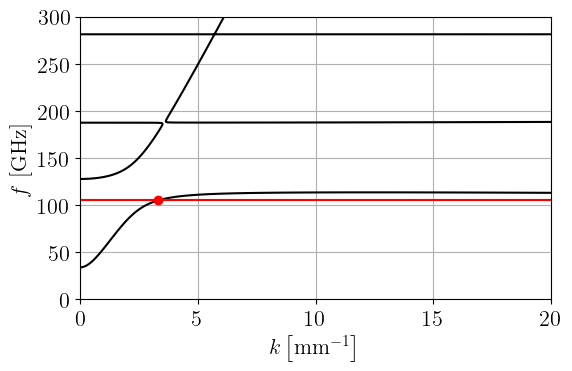

In [75]:
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0e-3
ki = np.linspace(0, 20e3, 1000)
omegai = 2*np.pi*np.linspace(1e-6, 300e9, 1000)
K, O = np.meshgrid(ki, omegai, indexing='ij')

k0 = get_k0(x0, omega0, 0, 10000)
print('k0', k0, ' m^-1')

plt.figure(figsize=(6, 4))
plt.contour(K * 1e-3, O/(2*np.pi) * 1e-9, D_vec(x0*np.ones_like(K), K, O), levels=[0], colors=['k'])
plt.plot(k0*1e-3, f0 * 1e-9, 'ro')
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
plt.plot(ki * 1e-3, f0*np.ones_like(ki) * 1e-9, 'r-')
plt.tight_layout()
plt.grid()
plt.show()

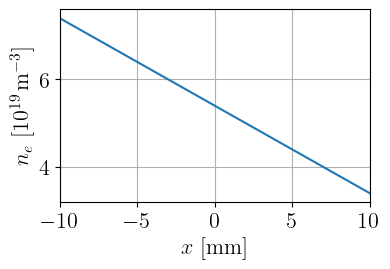

In [76]:
xi = np.linspace(-10e-3, 10e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, n_e(xi)*1e-19)
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(-10, 10)
plt.xlabel('$x$ [mm]')
plt.ylabel(r'$n_e$ [$10^{19} \, \mathrm{m^{-3}}$]')
plt.grid()
plt.show()

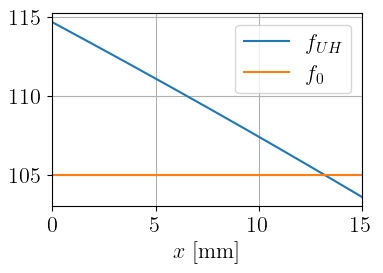

In [77]:
xi = np.linspace(0e-3, 15e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, np.sqrt(omega_c(xi)**2 + omega_p_squared(xi))/(2*np.pi)*1e-9, label=r'$f_{{UH}}$')
plt.plot(xi*1e3, omega0*np.ones_like(xi)/(2*np.pi)*1e-9, label=r'$f_0$')
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(0, 15)
plt.xlabel('$x$ [mm]')
plt.legend()
plt.grid()
plt.show()

In [78]:
max_gauss_quad_order = 3

def get_dispersion_manifold(x0, k0, omega0):
    ND = 1
    nt = 3000
    t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=30e-9, D=D, x_min = x0, tsteps=nt, ghost_ratio=0.05, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
    nt = i_end - i_start
    return t, xs, ks, zs, nt, i_start, i_end, x0, k0

def get_mgo_field(phi0, t, zs, i_start, i_end, i_save=[],
                       analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}},
                       'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}},):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [79]:
t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(x0, k0, omega0)
S = mgo.get_symplectic_tangent_trfm(zs, t, 1, i_start, i_end)
i_caust = np.argmin(np.abs(S[:, 0, 0]))

In [170]:
i_dt = int(nt/20)
i_save = np.arange(i_caust - i_dt, i_caust + i_dt, 1)
i_save

array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
       304, 305, 306, 307, 308])

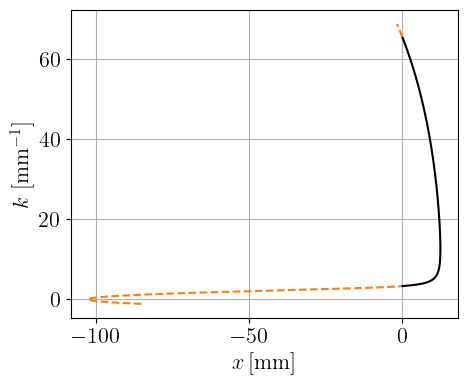

In [171]:
plt.figure(figsize=(5, 4))
plt.plot(xs[i_start:i_end]*1e3, ks[i_start:i_end]*1e-3, color='k')
plt.plot(xs[:i_start]*1e3, ks[:i_start]*1e-3, '--', color='tab:orange')
plt.plot(xs[i_end:]*1e3, ks[i_end:]*1e-3, '--', color='tab:orange')
plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
plt.xlabel(r'$x \, [\mathrm{mm}]$')
plt.grid()
plt.show()

In [172]:
# from scipy.integrate import cumulative_trapezoid

# gradtau_x = fd.grad(xs.squeeze(), t)[i_start:i_end]
# thetas = cumulative_trapezoid(ks[i_start:i_end].squeeze()*gradtau_x.squeeze(), t[i_start:i_end], initial=0)

# plt.plot(xs[i_start:i_start+i_caust], thetas[:i_caust], label='in')
# plt.plot(xs[i_start+i_caust:i_end], thetas[i_caust:], label='out')
# plt.legend()
# plt.grid()
# plt.show()

# #%%
# dkdt = fd.grad(ks.squeeze(), t)[i_start:i_end]
# dxdt = fd.grad(xs.squeeze(), t)[i_start:i_end]
# dkdx = dkdt/dxdt
# plt.plot(t[i_start:i_end], dkdx)
# # plt.ylim(-1, 1)
# plt.show()

# #%%
# import util as ut

# J = fd.grad(xs.squeeze(), t)[i_start:i_end]
# phase_shift = ut.continuous_angle_of_reals(J)
# sqrt_phi = ut.continuous_sqrt_of_reals(J[0]/J)
# # plt.plot(t[i_start:i_end]*1e9, J)
# # plt.plot(t[i_start:i_end]*1e9, phase_shift)
# plt.plot(t[i_start:i_end]*1e9, np.real(sqrt_phi))
# plt.plot(t[i_start:i_end]*1e9, np.imag(sqrt_phi))
# plt.grid()
# plt.show()

In [173]:
phi0 = 1
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 10}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 10}}}

mgo_branch_masks, mgo_ray_field, info, results, Nt, Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont)

In [174]:
mgo_field = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=mgo_branch_masks, ray_field=mgo_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='linear')

In [179]:
def get_phase(ray_field, i_caust):
    anglein = np.angle(ray_field[i_caust - 1])
    angleout = np.angle(ray_field[i_caust])
    Ain = np.abs(ray_field[i_caust - 1])
    Aout = np.abs(ray_field[i_caust])
    phase = -anglein - np.arctan(
        (Ain * np.cos(anglein - angleout) - Aout)
        /
        (Aout * np.sin(anglein - angleout)))
    return phase

phase = get_phase(mgo_ray_field, i_caust)

In [180]:
# mgo_field = mgo.superpose_ray_fields(phi0=1, x0=np.max(xs), xs=xs, branch_masks=mgo_branch_masks, ray_field = mgo_ray_field * np.exp(1j*phase),
#                                      i_start=i_start, i_end=i_end, interpolation_method='baryrat')

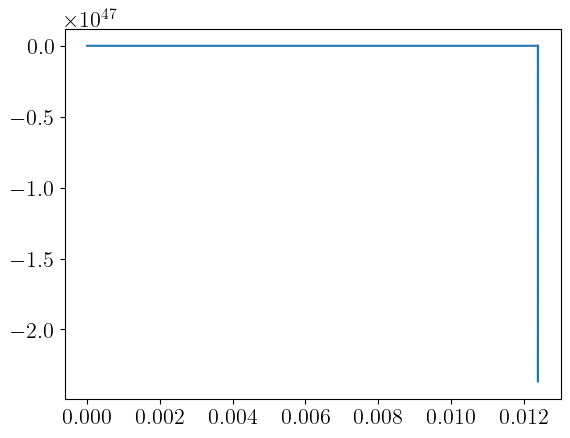

In [181]:
xi = np.linspace(0, 12.4e-3, 6000)
plt.plot(xi, np.real(mgo_field(xi)))
plt.show()
# plt.plot(xi, np.imag(mgo_field(xi)))

In [182]:
go_branch_masks, go_ray_field = mgo.get_go_field_1D(t, zs, phi0, i_start, i_end)
go_field = mgo.superpose_ray_fields(phi0=mgo_ray_field[np.argmin(xs - 10e-3)]*np.exp(1j*phase), x0=xs[np.argmin(xs - 10e-3)], xs=xs, branch_masks=go_branch_masks, ray_field=go_ray_field, i_start=i_start, i_end=i_end, interpolation_method='linear')

TypeError: __init__() got an unexpected keyword argument 'tol'

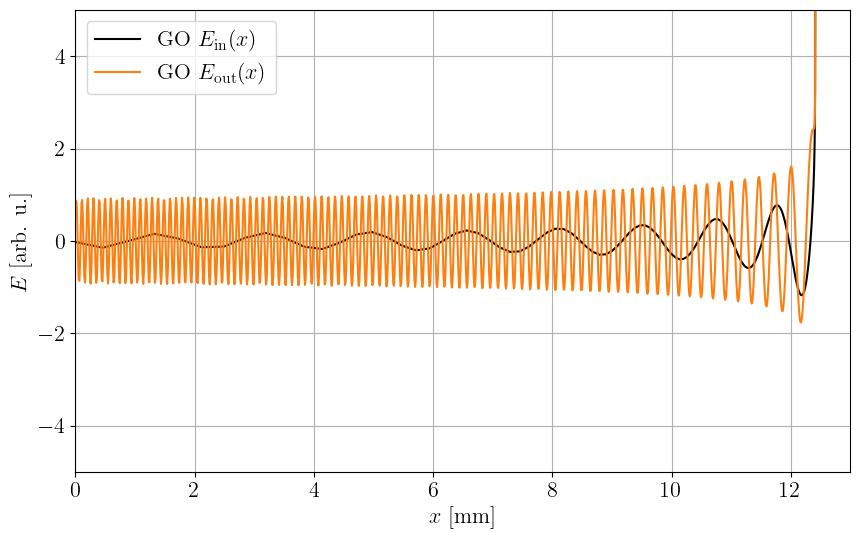

In [183]:
AGO = (mgo_ray_field[0] * np.exp(1j * phase)/go_ray_field[0])

plt.figure(figsize=(10, 6))
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e3*np.real(AGO * go_ray_field[:i_caust]), '-', color='k', label=r'GO $E_{\mathrm{in}}(x)$')
# plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e3*np.imag(AGO * go_ray_field[:i_caust]), '--', color='k', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start+i_caust:i_end]*1e3, 1e3*np.real(AGO * go_ray_field[i_caust:]), '-', color='tab:orange', label=r'GO $E_{\mathrm{out}}(x)$')
# plt.plot(xs[i_start+i_caust:i_end]*1e3, 1e3*np.imag(AGO * go_ray_field[i_caust:]), ':', color='tab:orange', label=r'GO $E_{\mathrm{out}}(x)$')
plt.ylim(-5, 5)
plt.xlim(0,13)
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E$ [arb. u.]')
plt.legend()
plt.grid()
plt.show()

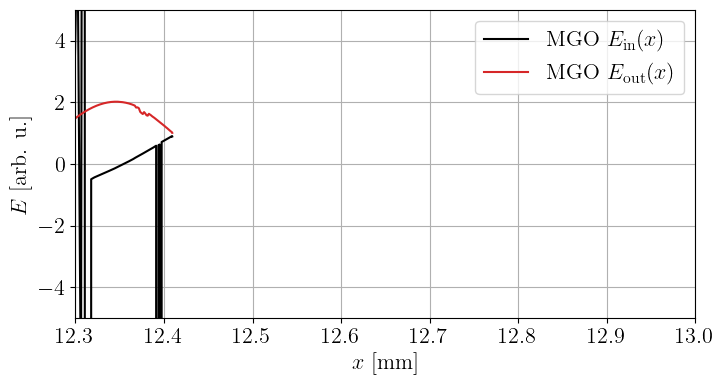

In [191]:
plt.figure(figsize=(8, 4))
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e3*np.real(mgo_ray_field[:i_caust] * np.exp(1j * phase)), '-', color='k', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start+i_caust:i_end]*1e3, 1e3*np.real(mgo_ray_field[i_caust:] * np.exp(1j * phase)), '-', color='tab:red', label=r'MGO $E_{\mathrm{out}}(x)$')
plt.ylim(-5, 5)
plt.xlim(12,13)
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E$ [arb. u.]')
plt.legend()
plt.grid()
plt.show()

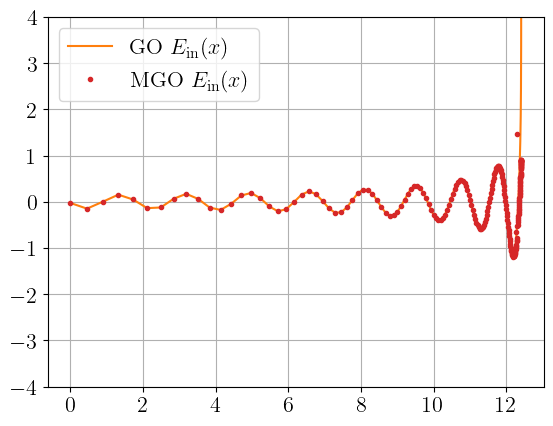

In [185]:
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e3*np.real(AGO * go_ray_field[:i_caust]), '-', color='tab:orange', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e3*np.real(mgo_ray_field[:i_caust] * np.exp(1j*phase)), '.', color='tab:red', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.legend()
plt.ylim(-4, 4)
plt.grid()
plt.show()

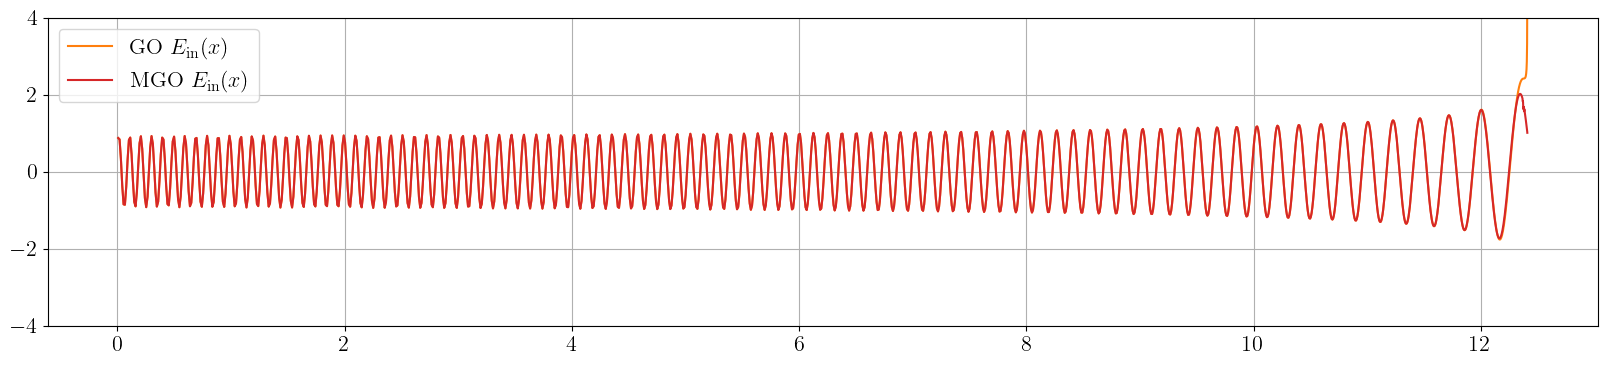

In [186]:
plt.figure(figsize=(20, 4))
plt.plot(xs[i_start+i_caust:i_end]*1e3, 1e3*np.real(AGO * go_ray_field[i_caust:]), '-', color='tab:orange', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start+i_caust:i_end]*1e3, 1e3*np.real(mgo_ray_field[i_caust:] * np.exp(1j*phase)), '-', color='tab:red', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.legend()
plt.ylim(-4, 4)
plt.grid()
plt.show()

In [388]:
i_insp = np.array(list(i_save[np.argsort(np.abs(mgo_ray_field[i_save]))[:-4:-1]]) + list(np.linspace(i_save[0], i_save[-1], 5).astype(int)) + [i_caust])
i_insp.sort()

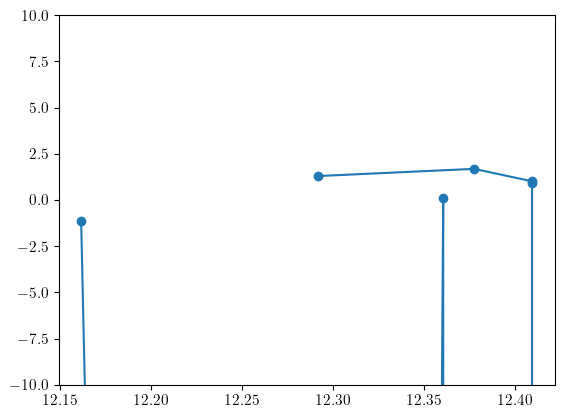

In [389]:
plt.plot(xs[i_start + i_insp]*1e3, 1e3*np.real(mgo_ray_field[i_insp]* np.exp(1j*phase)), '-o')
plt.ylim(-10, 10)
plt.show()

In [390]:
C = lambda l, sigma_p, sigma_m, lamb: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: lamb*np.exp(1j*sigma_m), lambda l: lamb*np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m, lamb: np.real(C(l, sigma_p, sigma_m, lamb))
C_I = lambda l, sigma_p, sigma_m, lamb: np.imag(C(l, sigma_p, sigma_m, lamb))

def get_eps(lamb, gauss_quad_order):
    l_j, _ = get_nodes_and_weights(gauss_quad_order)
    lmax = np.max(l_j)
    l_j = l_j.astype(np.complex_)

    epsmax = max(lamb * lmax)
    eps_R = np.linspace(-epsmax,epsmax, 1000)
    eps_I = np.linspace(-epsmax,epsmax, 1000)
    Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
    Eps = Eps_R + 1j*Eps_I
    return Eps_R, Eps_I, Eps, l_j

from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 14

cm = 1/2.54 # 1 cm = 1/2.54 inch

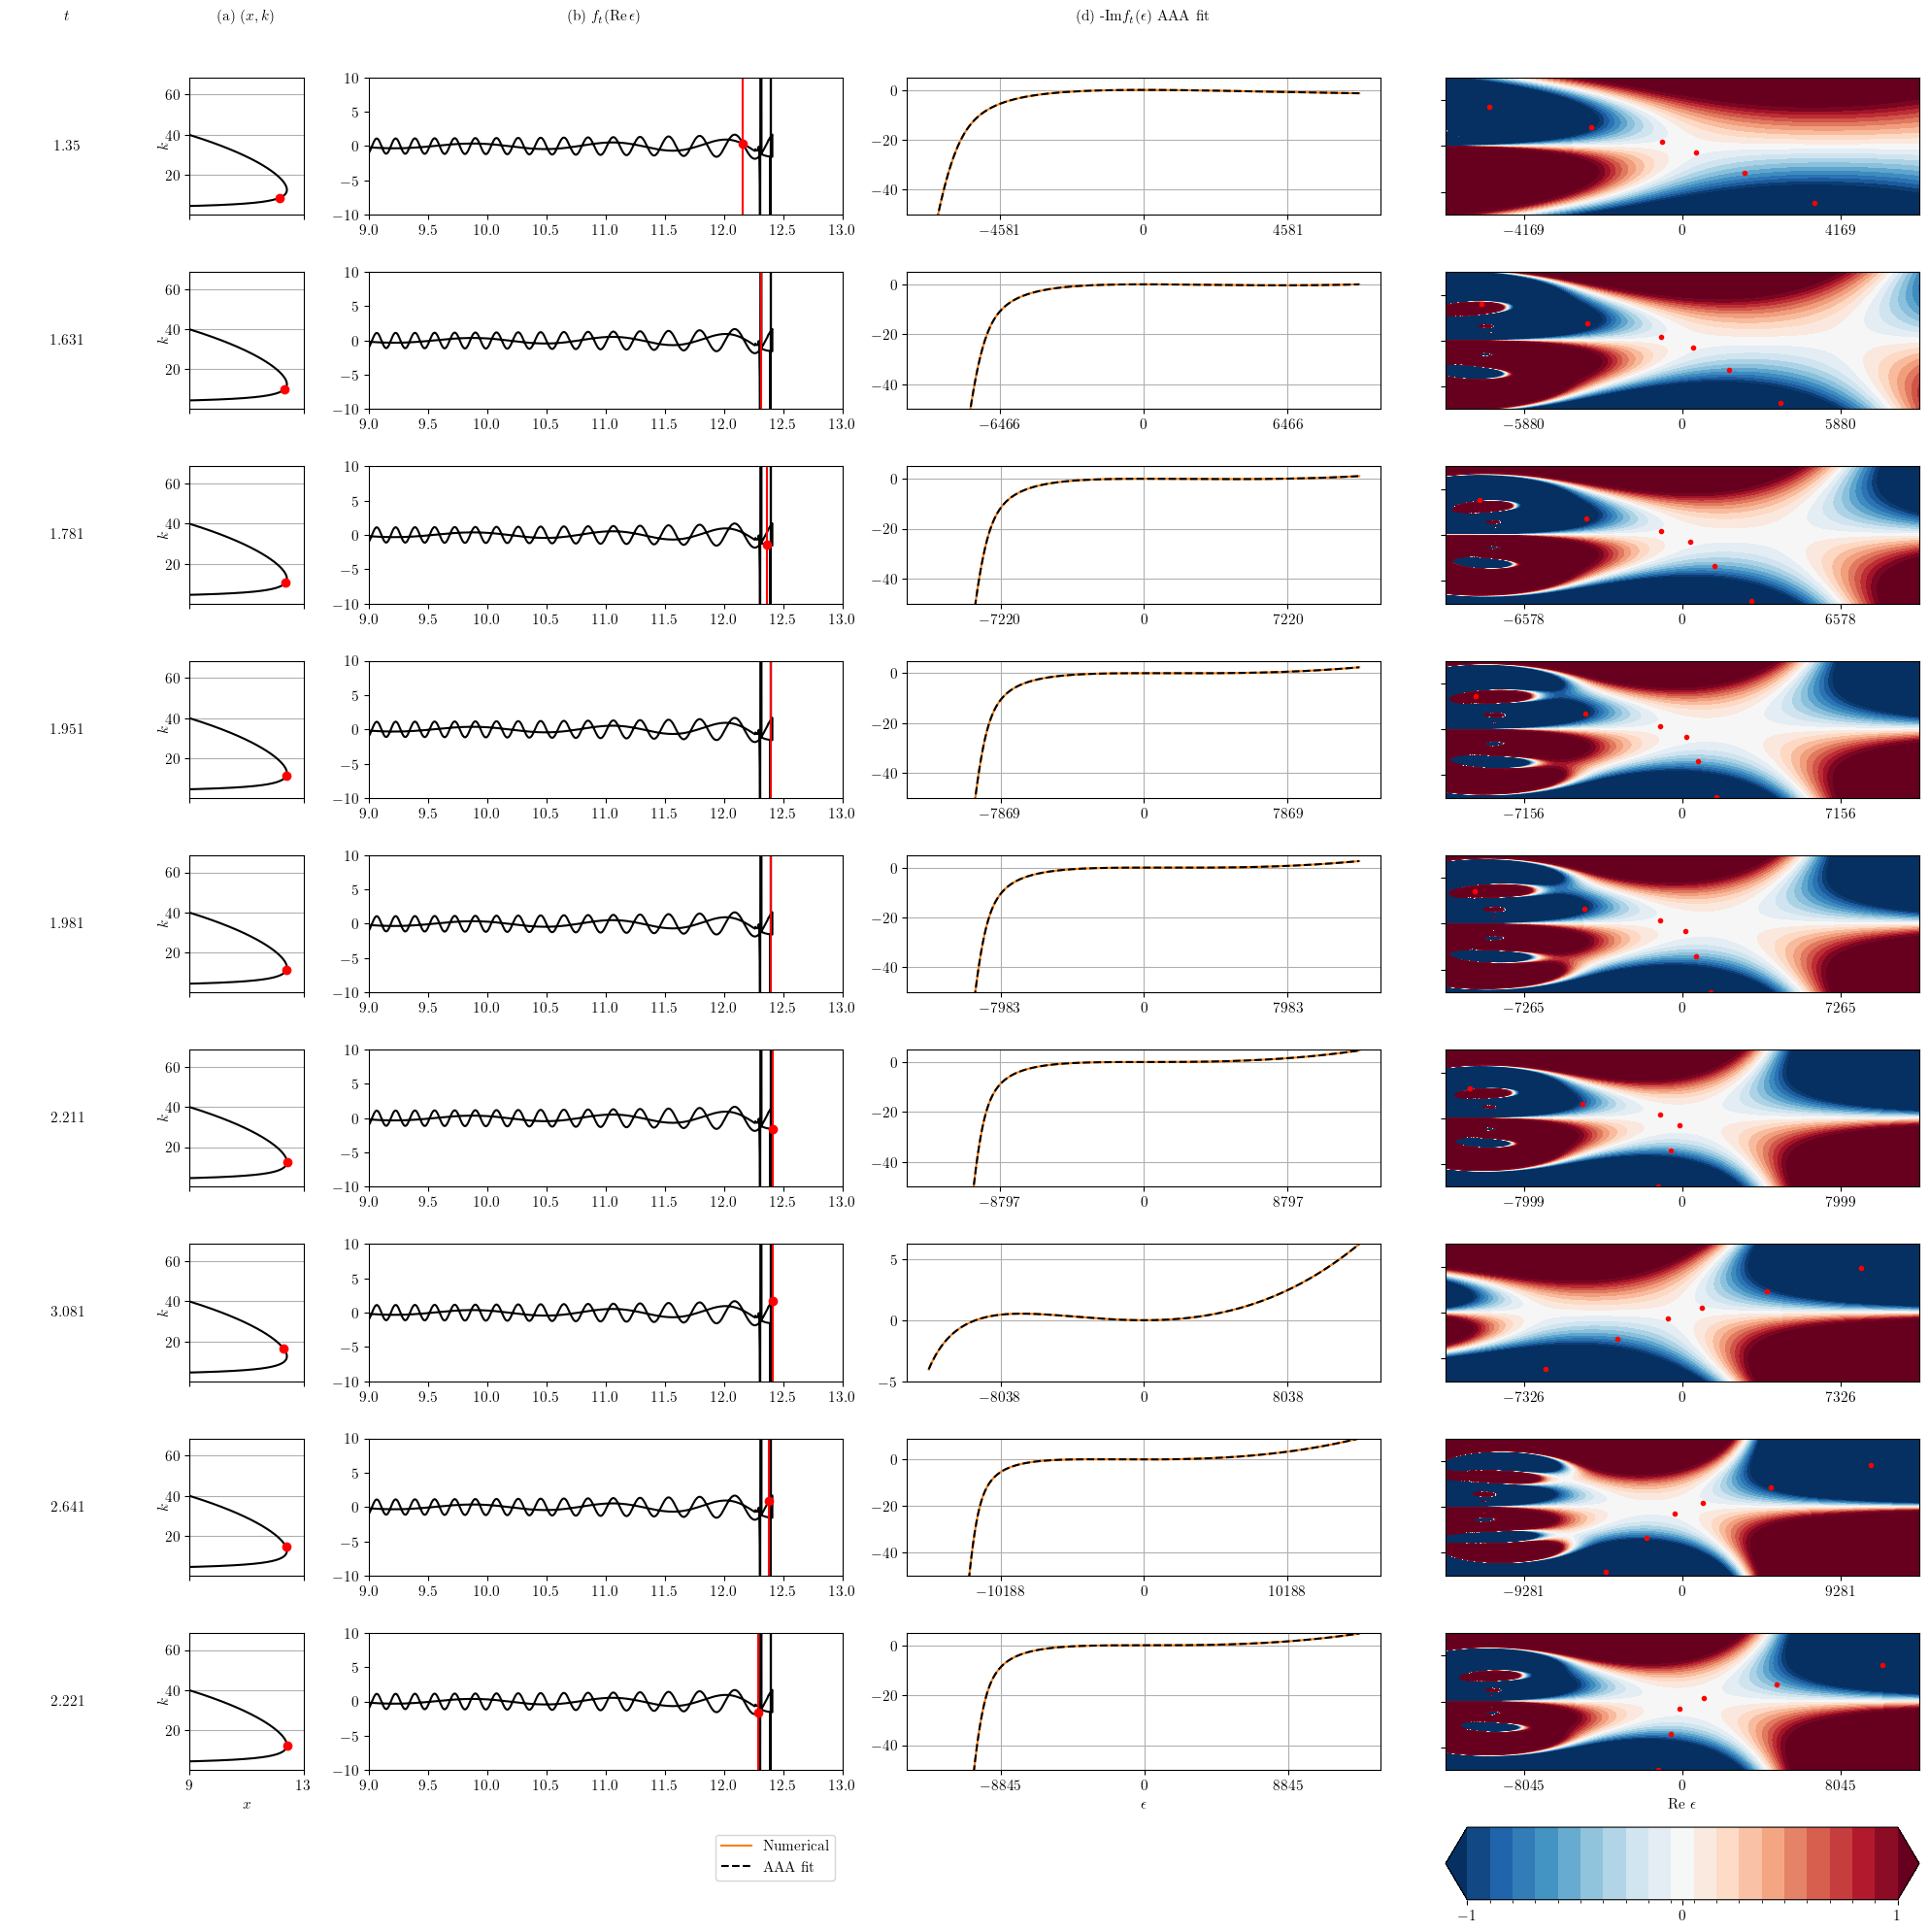

In [392]:
vmin, vmax = -1, 1
cmap = mpl.cm.RdBu_r
levels = np.linspace(vmin, vmax, 20)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')

Nr = len(i_insp)
nrows = 3+Nr*3
n_cols = 11
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == Nr - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 2), slice(2, 5), slice(5, 8), slice(8, 11)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $f_t(\mathrm{Re}\, \epsilon)$', r'(d) -Im$f_t(\epsilon)$ AAA fit']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

get_eps_xticks = lambda eps_rho: [-5]*int(np.min(eps_rho) <= -5) + [-2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [0] + [2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [5]*int(np.max(eps_rho) >= 5)

results_insp = [r for r in results if r['it'] in i_insp]
for i, result in enumerate(results_insp):
    t1, it_all, mask_t1, eps_rho, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), 0:1])
    ax.text(0.5, 0.5, r'$' + str(round(t1*1e9, 3)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.plot(xs[i_start:i_end]*1e3, ks[i_start:i_end]*1e-3, 'k-')
    ax.plot(xs[it_all]*1e3, ks[it_all]*1e-3, 'ro')
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([9, 13])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([9, 13], labels=[])
    ax.set_xlim(9, 13)

    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.plot(xs[i_start:i_end]*1e3, np.real(mgo_ray_field*1e3), 'k-')
    ax.plot(xs[i_start + i_insp[i]]*1e3, np.real(mgo_ray_field[i_insp[i]]*1e3), 'ro')
    ax.vlines(xs[i_start + i_insp[i]]*1e3, ax.get_ylim()[0], ax.get_ylim()[1], color='red')
    ax.set_ylim(-10, 10)
    ax.set_xlim(9, 13)

    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    ax.plot(eps_rho, f_t1, '-', color='tab:orange')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='k')
    ax.set_ylim(max(min(-5, np.min(f_t1)), -50), min(max(5, np.max(f_t1)), 50))
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')
    # ax.set_xticks(get_eps_xticks(eps_rho))
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(eps_rho))*2/3))))

    ax = fig.add_subplot(gs[row_range(i), col_ranges[4]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.r')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.r')
    # ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    plt.tick_params('y', labelleft=False)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_R))*2/3))))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_I))*2/3))))

ax = fig.add_subplot(gs[-2:, slice(col_ranges[2].start, col_ranges[2].stop)])
ax.plot(1, '-', color='tab:orange', label='Numerical')
ax.plot(1, '--', color='k', label='AAA fit')
plt.axis('off')
ax.legend()

cax = fig.add_subplot(gs[-2:, slice(col_ranges[-1].start, col_ranges[-1].stop)])
c_ticks = [vmin, 0, vmax]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cax, ticks=c_ticks, orientation='horizontal', extend='both')

plt.tight_layout()
plt.show()

In [33]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 11

cm = 1/2.54 # 1 cm = 1/2.54 inch

<Figure size 669.291x472.441 with 0 Axes>

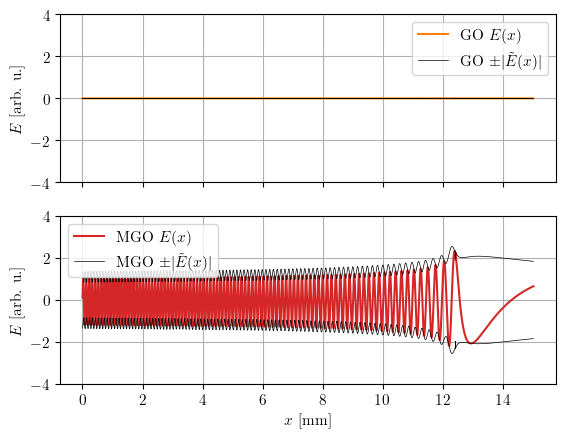

In [109]:
xi = np.linspace(0, 15e-3, 6000)
fig = plt.figure(constrained_layout=True, figsize=(17*cm, 12*cm))

fig, ax = plt.subplots(2, 1)
ax[0].plot(xi*1e3, np.real(go_field(xi)), '-', color='tab:orange', label=r'GO $E(x)$')
ax[0].plot(xi*1e3, np.abs(go_field(xi)), 'k-', linewidth=0.5, label=r'GO $\pm |\tilde{E}(x)|$')
ax[0].plot(xi*1e3, -np.abs(go_field(xi)), 'k-', linewidth=0.5)
ax[0].grid()
ax[0].legend()
# ax[0].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[0].sharex(ax[1])
ax[0].tick_params('x', labelbottom=False)
ax[0].set_ylim(-4, 4)
ax[0].set_ylabel(r'$E$ [arb. u.]')

ax[1].plot(xi*1e3, np.real(mgo_field(xi)), color='tab:red', label=r'MGO $E(x)$')
ax[1].plot(xi*1e3, np.abs(mgo_field(xi)), 'k-', linewidth=0.5, label=r'MGO $\pm |\tilde{E}(x)|$')
ax[1].plot(xi*1e3, -np.abs(mgo_field(xi)), 'k-', linewidth=0.5)
ax[1].grid()
ax[1].legend()
# ax[1].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[1].set_ylim(-4, 4)
ax[1].set_xlabel(r'$x$ [mm]')
ax[1].set_ylabel(r'$E$ [arb. u.]')

plt.show()

In [110]:
go_field_lin = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=go_branch_masks, ray_field=go_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='linear')
mgo_field_lin = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=mgo_branch_masks, ray_field=mgo_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='linear')

<Figure size 669.291x472.441 with 0 Axes>

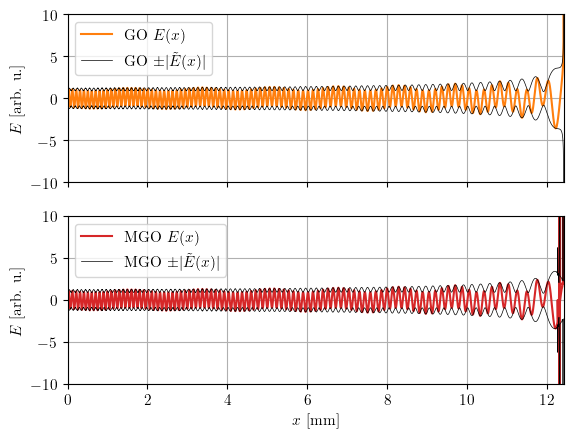

In [111]:
xi = np.linspace(0, 15e-3, 6000)
fig = plt.figure(constrained_layout=True, figsize=(17*cm, 12*cm))

fig, ax = plt.subplots(2, 1)
ax[0].plot(xi*1e3, np.real(go_field_lin(xi)), '-', color='tab:orange', label=r'GO $E(x)$')
ax[0].plot(xi*1e3, np.abs(go_field_lin(xi)), 'k-', linewidth=0.5, label=r'GO $\pm |\tilde{E}(x)|$')
ax[0].plot(xi*1e3, -np.abs(go_field_lin(xi)), 'k-', linewidth=0.5)
ax[0].grid()
ax[0].legend()
# ax[0].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[0].sharex(ax[1])
ax[0].tick_params('x', labelbottom=False)
ax[0].set_ylim(-10, 10)
ax[0].set_ylabel(r'$E$ [arb. u.]')

ax[1].plot(xi*1e3, np.real(mgo_field_lin(xi)), color='tab:red', label=r'MGO $E(x)$')
ax[1].plot(xi*1e3, np.abs(mgo_field_lin(xi)), 'k-', linewidth=0.5, label=r'MGO $\pm |\tilde{E}(x)|$')
ax[1].plot(xi*1e3, -np.abs(mgo_field_lin(xi)), 'k-', linewidth=0.5)
ax[1].grid()
ax[1].legend()
# ax[1].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[1].set_ylim(-10, 10)
ax[1].set_xlim(0, np.max(xs) * 1e3)
ax[1].set_xlabel(r'$x$ [mm]')
ax[1].set_ylabel(r'$E$ [arb. u.]')

plt.show()

- Normaliser, så indgående faser er ens
- Hvis vi kan sammenligne GO, MGO og EPOCH er vi i mål. Vi skal overbevise os om, at det ikke er et problem med fasen.
- Kig på Weber.
- Skriv til Nick
- Lav quadrature punkters farve om til noget mere synligt